# discharge notes

In [1]:
#configure for local eicu databse
import nltk
import os
print(os.getcwd())
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())

/Users/grovesdixon/gitreps/Insight_fellowship_project/project_framework

Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;

Configured for my local MIMIC database (modified tables):
	my_username = postgres
	my_dbname = mimic
	host = localhost
	my_schema_name = my_mimic_db
	my_schema = SET search_path to my_mimic_db;


### load noteevents

In [2]:
query = query_schema + 'select * from noteevents'

query = query_schema + """
select 
    hadm_id,
    text
from noteevents
where category = 'Discharge summary';
"""

df = pd.read_sql_query(query,con)
df.head()

,hadm_id,text
0,167853,Admission Date: [**2151-7-16**] Dischar...
1,107527,Admission Date: [**2118-6-2**] Discharg...
2,167118,Admission Date: [**2119-5-4**] D...
3,196489,Admission Date: [**2124-7-21**] ...
4,135453,Admission Date: [**2162-3-3**] D...


### clean the text
remove frequent endlines and bracketted strings for protected information

In [3]:
ctext = df['text']
ctext = pd.Series([x.lower() for x in ctext])
replacements = {'\[\*\*.*\*\*\]': 'REMOVEDTEXT',
               '\n': ' '}
ctext = ctext.replace(replacements, regex=True)
df['text'] = ctext
df.head()

,hadm_id,text
0,167853,admission date: REMOVEDTEXT service: addend...
1,107527,admission date: REMOVEDTEXT date of birth: ...
2,167118,admission date: REMOVEDTEXT service: cardio...
3,196489,admission date: REMOVEDTEXT service: medici...
4,135453,admission date: REMOVEDTEXT date of birth: ...


### call presence of elements
There are particular elements that appear in the notes, but are not always present. Will use the presence of these as potential features.

In [4]:
#set up list of elements found in the discharge notes
element_list = ['admission date:',
                'chief complaint:',
                'sex:',
               'history of present illness:']


#split out the text elements
tdat = df.loc[:,['hadm_id'].copy()]
for e in element_list:
    #first assign presence absence
    print('{}...'.format(e))
    pa_col = e.replace(':', '') + '_presnt'
    df[pa_col] = df['text'].str.contains(e).astype(int)
    print('\t{} instances detected out of {} rows'.format(np.sum(df[pa_col]), df.shape[0]))
df.head()

admission date:...
	59585 instances detected out of 59652 rows
chief complaint:...
	41370 instances detected out of 59652 rows
sex:...
	51905 instances detected out of 59652 rows
history of present illness:...
	50578 instances detected out of 59652 rows


,hadm_id,text,admission date_presnt,chief complaint_presnt,sex_presnt,history of present illness_presnt
0,167853,admission date: REMOVEDTEXT service: addend...,1,0,0,0
1,107527,admission date: REMOVEDTEXT date of birth: ...,1,0,1,1
2,167118,admission date: REMOVEDTEXT service: cardio...,1,1,0,1
3,196489,admission date: REMOVEDTEXT service: medici...,1,1,0,1
4,135453,admission date: REMOVEDTEXT date of birth: ...,1,1,1,1


# get word frequencies 

In [5]:
#prepare data
tdat = df.loc[:,['hadm_id', 'text']].copy()
tdat.index = tdat['hadm_id']
tdat = tdat.loc[~tdat.index.duplicated(keep='first')]

### get tokens
split notes into tokens and remove stopwords

In [6]:
from nltk.corpus import stopwords

#function to generate and clean the tokens
def clean_tokens(x):
    x=pd.Series(x.split(), dtype='object')
    return list(x[~x.isin(stopwords.words('english'))])

#tokenize
token_df = tdat.copy()
token_df['text'] = token_df['text'].apply(clean_tokens) 
token_df

#gather word count as a feature
wc_df = token_df.copy()
wc_df['wc'] = wc_df['text'].apply(len)
wc_df = wc_df.drop('text', 1)

### get word frequencies

In [7]:
#get word frequencies
print('getting frequencies...')
freq_df = token_df.copy()
freq_df['text'] = freq_df['text'].apply(nltk.FreqDist)
freq_df.head()

getting frequencies...


,hadm_id,text
hadm_id,,
167853,167853,"{'admission': 1, 'date:': 1, 'REMOVEDTEXT': 5,..."
107527,107527,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 21..."
167118,167118,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 35..."
196489,196489,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 30..."
135453,135453,"{'admission': 2, 'date:': 1, 'REMOVEDTEXT': 17..."


### format into long df

In [8]:
#build dataframe cor column
c='text'
fdf_list = []
for i in freq_df.index:
    sub_df = pd.DataFrame.from_dict(freq_df.loc[i,c], orient='index')
    sub_df['hadm_id'] = i
    fdf_list.append(sub_df)
fdat = pd.concat(fdf_list)
fdat.columns = ['count', 'hadm_id']
fdat['word'] = fdat.index

### select words based on content and frequency
also remove short words and numbers

In [9]:
word_counts = fdat['word'].value_counts()
print('starting total words = {}'.format(len(word_counts)))
keep = word_counts.index[(word_counts > 25) & (word_counts < 10000)].to_series()
word_lengths = keep.str.len()
keep = keep[word_lengths>3]
keep = keep[~keep.str.contains('[^\w]')]
keep = keep[~keep.str.contains('[\d]')]
keep = keep[~keep.str.contains('__')]
keep = keep[~keep.str.contains('REMOVEDTEXT')]

print('total words appearing kept = {}'.format(len(keep)))
common_fdat = fdat.loc[fdat['word'].isin(keep),:]
common_fdat.head()

starting total words = 664696
total words appearing kept = 14085


,count,hadm_id,word
radiologic,2,167853,radiologic
studies,1,167853,studies
included,1,167853,included
confirmed,1,167853,confirmed
cavitary,1,167853,cavitary


#### pivot and convert to present absence

In [10]:
dn_dat = common_fdat.pivot(index='hadm_id', columns='word', values='count').fillna(value=0).astype('int')
dn_dat

word,abacavir,abandoned,abated,abbreviated,abcess,abcesses,abdm,abdom,abdomenal,abdominial,...,zones,zonisamide,zoster,zosyn,zydis,zygoma,zygomatic,zyprexa,zyrtec,zyvox
hadm_id,,,,,,,,,,,,,,,,,,,,,
100001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### upload training outcomes

In [11]:
#load training outcomes
import joblib
y_train = joblib.load(open(my_local_data_dir + 'y_train.joblib', 'rb')) #build this with feature_engineering.ipynb
train_pos_hadm_ids = y_train.index[y_train==1]
print(len(train_pos_hadm_ids))
y_train

1724


hadm_id
159128    0
113499    0
163615    0
157427    0
176972    0
         ..
155274    0
157212    0
141275    0
113262    0
107169    0
Name: hrrd_penalized, Length: 35164, dtype: int64

### select on presence

In [12]:
padn_dat = dn_dat.copy() > 0
padn_dat = padn_dat.astype(int).loc[padn_dat.index.isin(train_pos_hadm_ids)]
freqs = padn_dat.sum() / len(padn_dat.index.unique())
keep = freqs.index[freqs > 1/10]
print('{} of {} total words appear in more than 10% of notes for positive patients'.format(len(keep), dn_dat.shape[0]))
print(keep)
notes_dat = dn_dat.loc[:,keep]
notes_dat.shape

482 of 52704 total words appear in more than 10% of notes for positive patients
Index(['abnormal', 'acid', 'active', 'additional', 'adequate', 'advanced',
       'aerosol', 'afebrile', 'afib', 'aggressive',
       ...
       'weakness', 'weigh', 'went', 'wheezes', 'wife', 'woman', 'worked',
       'workup', 'worse', 'wound'],
      dtype='object', name='word', length=482)


(52704, 482)

### scale

In [13]:
#Note the 'total' columns created for presence absence sets above are already scaled
#scale the dataframe
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
notes_dat[notes_dat.columns] = scaler.fit_transform(notes_dat[notes_dat.columns])
print('maximum value in dataframe = {}'.format(max(notes_dat.max())))

maximum value in dataframe = 1.0


## select features

#### set up training set for feature selection

In [14]:
mdat = pd.merge(notes_dat, pd.DataFrame(y_train), how = 'inner', on='hadm_id')
print(mdat.shape)
mdat
X_train = mdat.drop(columns = ['hrrd_penalized'])
y_train = mdat['hrrd_penalized']

(34293, 483)


#### optimize hyperparameters for feature selection model

In [15]:
#------- OPTIMIZE RF
RAND_SEED=321
N_JOBS=1
#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [30,40,50,60]
min_samples_split = [2]
min_samples_leaf = [1]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# ### run random search
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'f1',
                               cv = 4,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = N_JOBS)
rf_search.fit(X_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=100. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   7.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   7.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   7.5s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   9.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   9.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   9.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   9.1s
[CV] min_samples_split=2, min_samples_leaf=1, max

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  2.5min finished


{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 60}


#### fit model with optimized parameters

In [16]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 60}


RandomForestClassifier(max_depth=60, n_jobs=1, random_state=321)

### performance

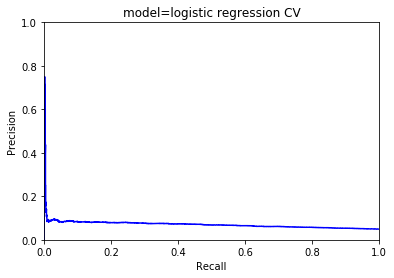

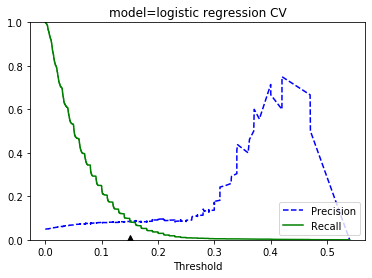

Confusion matrix for threshold = 0.15:
[[31065  1541]
 [ 1542   145]]
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     32606
           1       0.09      0.09      0.09      1687

    accuracy                           0.91     34293
   macro avg       0.52      0.52      0.52     34293
weighted avg       0.91      0.91      0.91     34293



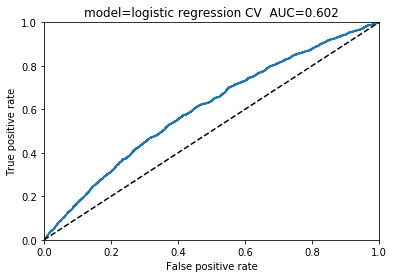

0.602


In [17]:
#logistic regression cross validation
probs_rf_cv = cross_val_predict(rf_opt, X_train, y_train, cv=4, method="predict_proba", n_jobs=3)
scores_rf_cv = probs_rf_cv[:, 1]
rf_perf_cv = get_model_performance('logistic regression CV', X_train, scores_rf_cv, y_train, pos_label=1)
print(rf_perf_cv['auc'])

#### look at feature importances from optimized model

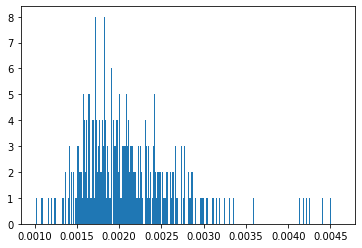

In [18]:
importances = rf_opt.feature_importances_
plt.hist(importances, bins=500)
plt.show()

### select features

In [23]:
CUT=0.003
tdn_dat = notes_dat.loc[:,notes_dat.columns[importances > CUT]]
tdn_dat.shape
pd.DataFrame({'importance' : importances,
             'pass' : importances > CUT}).to_csv('../data/for_plotting/discharge_note_importances.csv', index=False)

### write out to database

In [24]:
#write out results to my mimic
tdn_dat.to_sql('discharge_note_features', engine, if_exists='replace')

#### optionally write out to csv

In [25]:
tdn_dat.to_csv(my_local_data_dir + 'discharge_note_features.csv')